<a href="https://colab.research.google.com/github/bominwang/inviscid-viscid-flow-correct-neural-network/blob/HB-2-surface-pressure/HB_2_SURFACE_PRESSURE_PRED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

无粘网络构建

In [12]:
# 加载谷歌云盘
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
# 加载相应模块
import pandas as pd
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
from torch.utils import 
import matplotlib.pyplot as plt

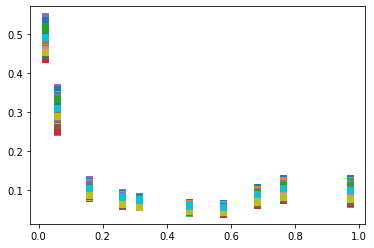

In [34]:
# 加载数据集
ins = pd.read_csv('drive/MyDrive/Colab Notebooks/bm_wang/data/HB2/inv/inv_input_data.csv')
ins = np.array(ins)
labs = pd.read_csv('drive/MyDrive/Colab Notebooks/bm_wang/data/HB2/inv/inv_output_data.csv')
labs = np.array(labs)
positions = labs[:,0].reshape(-1,10)
labs = labs[:,1].reshape(-1,10)
data_size = np.size(labs,0)
# 样本展示
for i in range(data_size):
  position = positions[i, :]
  lab = labs[i, :]
  plt.plot(position, lab, 's')


In [45]:
# 构建训练数据集
train_data_ins = torch.from_numpy(ins[0:150, :])
train_data_labs = torch.from_numpy(labs[0:150, :])

test_data_ins = torch.from_numpy(ins[150:201, :])
test_data_labs = torch.from_numpy(labs[150:201, :])